In [1]:
from src.modules.dataset import FlickrDataset, Collate
from torch.utils.data import DataLoader
from src.modules.model import CNNtoRNN
import torch
from tqdm import tqdm
import plotly.express as px
import plotly.io as pio
import torchvision.transforms as T

pio.renderers.default = 'png'

In [2]:
imgs_path = '/mnt/s/CV/data/Images'
captions_path = '/mnt/s/CV/data/captions.txt'

In [3]:
batch_size = 8
embed_size = 512
hidden_size = 512
num_features = 2048
num_epochs = 1

In [4]:
dataset = FlickrDataset(imgs_path, captions_path)
collate = Collate(pad_idx=dataset.vocab.word2idx['<PAD>'])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)

In [5]:
vocab_size = len(dataset.vocab)
vocab = dataset.vocab
model = CNNtoRNN(
    embed_size=embed_size,
    num_features=num_features,
    hidden_size=hidden_size,
    vocab_size=vocab_size
).cuda()

In [6]:
img_batch, cap_batch = next(iter(dataloader))
img_batch = img_batch.cuda()
cap_batch = cap_batch.cuda()

In [7]:
# model.forward(img_batch, cap_batch)

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize = T.Normalize(
   mean = [-m/s for m, s in zip(mean, std)],
   std = [1/s for s in std]
)

Epoch: 0


100%|██████████| 5057/5057 [11:25<00:00,  7.38it/s]


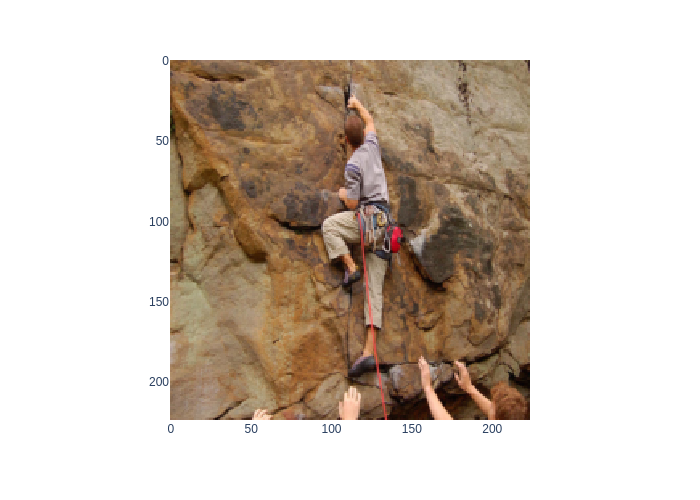

a man in a red shirt is standing on a swing . <EOS>
Loss: 3.057



In [9]:
lr = 1e-4
optimizer = torch.optim.Adam(
    params=model.parameters(), 
    lr=lr
)
criterion = torch.nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<PAD>']).cuda()

for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')
    for i, (imgs, captions) in enumerate(tqdm(dataloader), start=1):
        imgs = imgs.cuda()
        captions: torch.Tensor = captions.cuda()
        captions_input = captions[:, :-1]
        captions_expected = captions[:, 1:]
        optimizer.zero_grad()
        outputs: torch.Tensor = model(
            imgs,
            captions_input
        )
        loss: torch.Tensor = criterion(
            outputs.contiguous().view(-1, vocab_size),
            captions_expected.contiguous().view(-1)
        )
        loss.backward()
        optimizer.step()
    px.imshow(inv_normalize(imgs[0].cpu()).permute(1, 2, 0)).show()
    preds = model.caption_image(imgs[0])
    preds = [vocab.idx2word[idx] for idx in preds]
    print(' '.join(preds))
    print('Loss:', round(loss.item(), 3))
    print()
torch.save(model.state_dict(), 'weights_lstm.ckpt')

In [10]:
model.load_state_dict(torch.load('weights_lstm.ckpt'))

<All keys matched successfully>

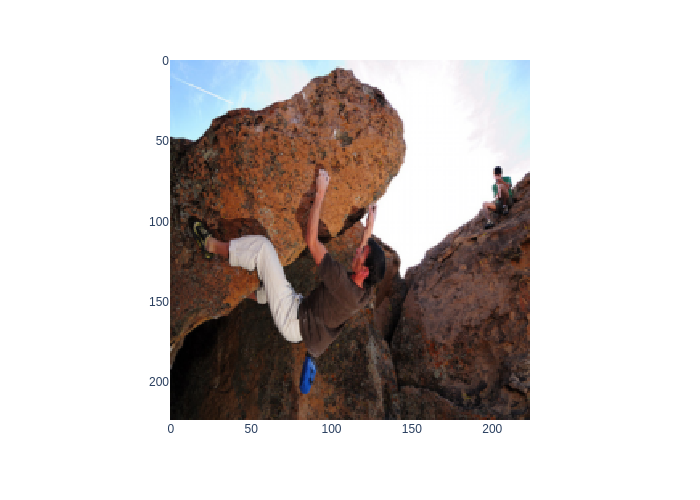

['a', 'man', 'is', 'standing', 'on', 'a', 'skateboard', '.', '<EOS>']

In [16]:
img_batch, cap_batch = next(iter(dataloader))
img = img_batch[0].cuda()
cap = cap_batch[0].cuda()
idx = 1
px.imshow(inv_normalize(img.cpu()).permute(1, 2, 0)).show()
[vocab.idx2word[idx] for idx in model.caption_image(img)]

In [21]:
torch.cat([torch.randn((8, 100, 512)), torch.randn((8, 20, 512))], dim=2).shape

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 100 but got size 20 for tensor number 1 in the list.